In [1]:
import torchvision
import torch
import torch.nn as nn
from torchsummary import summary

In [2]:
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
sns.set_style("darkgrid")

In [5]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [6]:
PATH = "../../data/asl_alphabet_train/"

In [7]:
dataset = datasets.ImageFolder(PATH, transform=transform)

In [8]:
n = len(dataset)

In [9]:
torch.manual_seed(1)
indices = torch.randperm(n)

In [10]:
test_proportion = 0.2 # 20 percent of data used for testing
test_size = int(n * test_proportion)

In [11]:
train_dataset = torch.utils.data.Subset(dataset, indices[test_size:])
test_dataset = torch.utils.data.Subset(dataset, indices[:test_size])

In [12]:
len(train_dataset)

69600

In [13]:
len(test_dataset)

17400

In [14]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=32, 
                                               shuffle=True, 
                                               num_workers=4)

test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=32,
                                              shuffle=False,
                                              num_workers=4)

In [16]:
classes = dataset.classes

In [17]:
class ASLNeuralNet(nn.Module):
    
    def __init__(self, num_classes=1000):
        super(ASLNeuralNet, self).__init__()
        # declare all the layers for feature extraction
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(in_channels=192, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),)
        # declare all the layers for classification
        self.classifier = nn.Sequential(
            nn.Linear(6 * 6 * 256, 200),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(200, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500, num_classes),)
        
    def forward(self, x):
        # apply the feature extractor in the input
        x = self.features(x)
        # squeeze the spatial dimensions in one
        x = x.view(-1, 6 * 6 * 256)
        # classify the images
        x = self.classifier(x) 
        return x

In [18]:
model = ASLNeuralNet(num_classes=29).to(DEVICE)

In [19]:
# sanity check
print(model)

ASLNeuralNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=200, out_features=500, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=500, out_features=29, bias=True)
  )
)


In [20]:
from torchsummary import summary
summary(model, (3, 200, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 49, 49]          23,296
              ReLU-2           [-1, 64, 49, 49]               0
         MaxPool2d-3           [-1, 64, 24, 24]               0
            Conv2d-4          [-1, 192, 26, 26]         110,784
              ReLU-5          [-1, 192, 26, 26]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 256, 13, 13]         442,624
              ReLU-8          [-1, 256, 13, 13]               0
         MaxPool2d-9            [-1, 256, 6, 6]               0
           Linear-10                  [-1, 200]       1,843,400
             ReLU-11                  [-1, 200]               0
          Dropout-12                  [-1, 200]               0
           Linear-13                  [-1, 500]         100,500
             ReLU-14                  [

In [21]:
batch_size = 64

In [22]:
def train_one_epoch(train_loader, model, device, optimizer, log_interval, epoch):
    model.train()
    losses = []
    counter = []
    
    for i, (img, label) in enumerate(train_loader):
        img, label = img.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()   
        if (i+1) % log_interval == 0:
            losses.append(loss.item())
            counter.append(
                (i * batch_size) + img.size(0) + epoch * len(train_loader.dataset))

    return losses, counter

In [23]:
def test_one_epoch(test_loader, model, device):
    model.eval()
    test_loss = 0
    num_correct = 0
    
    with torch.no_grad():
        for i, (img, label) in enumerate(test_loader):
            img, label = img.to(device), label.to(device)
            output = model(img)
            pred = torch.argmax(output, dim=1)
            num_correct += (pred == label).sum().item()
            test_loss += criterion(output, label).item()
            
    test_loss /= len(test_loader.dataset)
    return test_loss, num_correct

In [24]:
criterion = nn.CrossEntropyLoss()

In [25]:
no_of_epochs = 10

In [26]:
lr = 0.01

log_interval = 100

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

train_losses = []
train_counter = []
test_losses = []
test_correct = []
train_correct = []
for epoch in tqdm(range(no_of_epochs)):
    train_loss, counter = train_one_epoch(train_dataloader, model, DEVICE, optimizer, log_interval, epoch)
    test_loss, num_correct = test_one_epoch(test_dataloader, model, DEVICE)
    _, num_correct_train = test_one_epoch(train_dataloader, model, DEVICE)

    # record results
    train_losses.extend(train_loss)
    train_counter.extend(counter)
    test_losses.append(test_loss)
    test_correct.append(num_correct)
    train_correct.append(num_correct_train)

100%|██████████| 10/10 [40:23<00:00, 242.39s/it]


In [27]:
print(f"test accuracy: {test_correct[-1]/len(test_dataloader.dataset)}")
print(f"train accuracy: {train_correct[-1]/len(train_dataloader.dataset)}")

test accuracy: 0.985
train accuracy: 0.9872557471264368


In [28]:
SAVE_PATH = "../../data/googlenet_asl_v0.pth"

In [29]:
torch.save(model, SAVE_PATH)

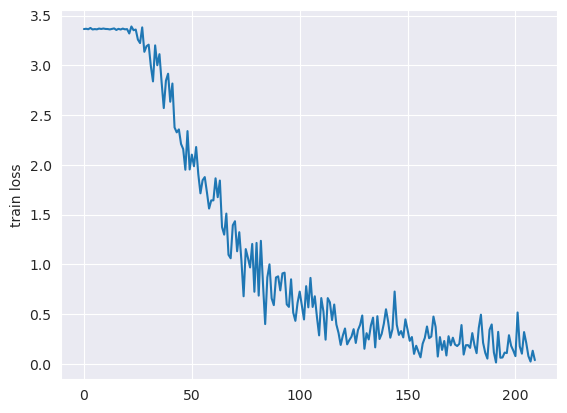

In [30]:
sns.lineplot(train_losses)
plt.ylabel("train loss");

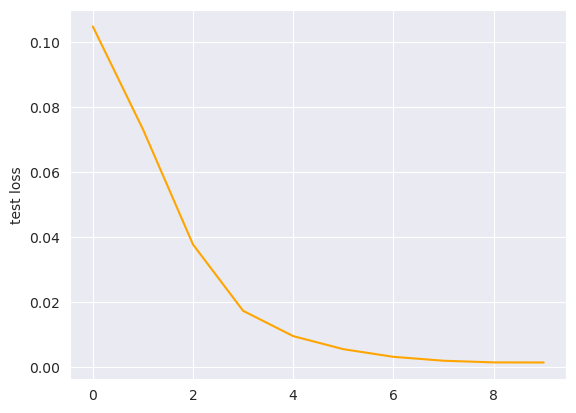

In [31]:
sns.lineplot(test_losses, color="orange")
plt.ylabel("test loss");